In [1]:
# Importing all libraries

import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sklearn.decomposition
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from random import normalvariate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import tqdm
from tqdm import trange

import seaborn
import builtins
from IPython.display import clear_output

In [5]:
# data preprocessing
df = pd.read_csv('heart_2020_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

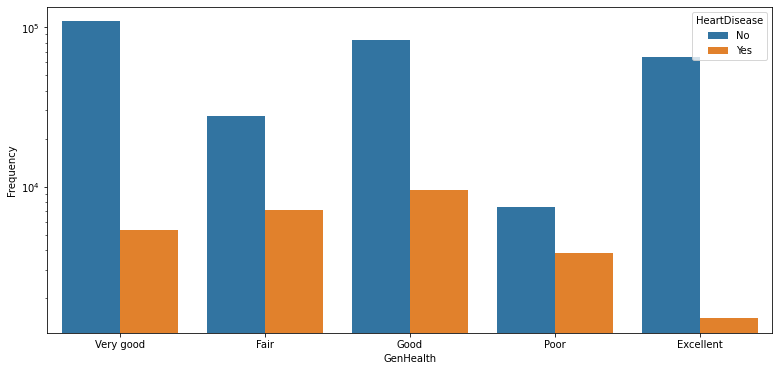

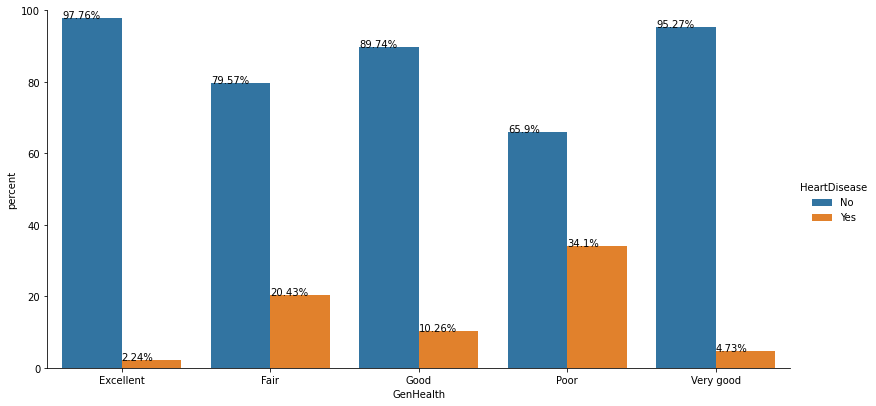

In [6]:
# GenHealth analysis

plt.figure(figsize = (13,6))
seaborn.countplot(x = df['GenHealth'], hue = 'HeartDisease', data = df, log=True)
plt.xlabel('GenHealth')
plt.ylabel('Frequency')
plt.show()

x,y = 'GenHealth', 'HeartDisease'
df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = seaborn.catplot(x=x, y='percent', hue=y, kind='bar', data=df1, height=5.5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [7]:
# Categorial data simplification
df["AgeCategory"] = df["AgeCategory"].replace('18-24', 1)
df["AgeCategory"] = df["AgeCategory"].replace('25-29', 2)
df["AgeCategory"] = df["AgeCategory"].replace('30-34', 3)
df["AgeCategory"] = df["AgeCategory"].replace('35-39', 4)
df["AgeCategory"] = df["AgeCategory"].replace('40-44', 5)
df["AgeCategory"] = df["AgeCategory"].replace('45-49', 6)
df["AgeCategory"] = df["AgeCategory"].replace('50-54', 7)
df["AgeCategory"] = df["AgeCategory"].replace('55-59', 8)
df["AgeCategory"] = df["AgeCategory"].replace('60-64', 9)
df["AgeCategory"] = df["AgeCategory"].replace('65-69', 10)
df["AgeCategory"] = df["AgeCategory"].replace('70-74', 11)
df["AgeCategory"] = df["AgeCategory"].replace('75-79', 12)
df["AgeCategory"] = df["AgeCategory"].replace('80 or older', 13)

df["GenHealth"] = df["GenHealth"].replace('Very good', 'Excellent')
df["GenHealth"] = df["GenHealth"].replace('Fair', 'Poor')

In [8]:
#One-hot encoding of the categorial features
def cat_to_num(data): 
  categories = set(data) 
  features = {}
  for cat in categories:
      binary = (data == cat)
      if len(set(binary)) == 1:
        continue
      new_key = f'{data.name}={cat}'
      features[new_key] = binary.astype("int")
  return pd.DataFrame(features)


def prepare_data(data): 
    features = data.drop(["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "Sex", "Race", "Diabetic", "PhysicalActivity", "GenHealth", "Asthma", "KidneyDisease", "SkinCancer"], axis=1)
    features = features.join(cat_to_num(data['Smoking']))
    features = features.join(cat_to_num(data['AlcoholDrinking']))
    features = features.join(cat_to_num(data['Stroke']))
    features = features.join(cat_to_num(data['DiffWalking']))
    features = features.join(cat_to_num(data['Sex']))
    features = features.join(cat_to_num(data['Race']))
    features = features.join(cat_to_num(data['Diabetic']))
    features = features.join(cat_to_num(data['GenHealth']))
    features = features.join(cat_to_num(data['Asthma']))
    features = features.join(cat_to_num(data['KidneyDisease']))
    features = features.join(cat_to_num(data['SkinCancer']))
    return features

features = prepare_data(df)

def change(col):
    if col=='Yes':
        return 1
    elif col=='No':
        return 0
        
df['HeartDisease'] = df['HeartDisease'].apply(change)
results_df = df['HeartDisease']

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

features_train, features_test, y_train, y_test = train_test_split(features, results_df, test_size=0.2, random_state=42) 

Using device: cpu


In [10]:
# Using preselected with Boruta features 

i = 0
array = [True, False, False,  True, False, False, True, False, False,
         False,  True,  False,  True,  False,  True, False, False,  True,
         False, False, False, False,  True, False,  True,  True,  True,
         True, False, False,  False,  True, False, True]
        
for feature in features:
    if array[i] == False: 
      features_train = features_train.drop(feature, axis = 1)
      features_test = features_test.drop(feature, axis = 1)
    i+=1


X_train, X_validation, y_train, y_validation = train_test_split(features_train, y_train, test_size=0.2, random_state=42) 
X_test = features_test

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

X_train = X_train.astype(np.double)
X_validation = X_validation.astype(np.double)
X_test = X_test.astype(np.double)
y_train = y_train.to_numpy() 
y_validation = y_validation.to_numpy() 
y_test = y_test.to_numpy() 

In [11]:
# Weighted sampler for unbalanced data

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[np.argmax(t)] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.FloatTensor'), len(samples_weight))

In [12]:
# Create new dataset with selected features

class hd_dataset (Dataset):
  def __init__ (self, X, Y):
    self.x = X
    self.y = Y

  def __getitem__(self, index):      
    return self.x[index], self.y[index]


  def __len__(self):
    self.len = self.x.shape[0]
    return self.len


X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_validation = torch.tensor(X_validation).to(device)
y_validation = torch.tensor(y_validation).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

train_set = hd_dataset (X_train, y_train)
validation_set = hd_dataset (X_validation, y_validation)
test_set = hd_dataset (X_test, y_test)

In [13]:
# Importing toy example data

file1 = open("memristor_mean_weights.txt")
content = file1.readlines()
memristor_w=[]
for line in content:
    memristor_w.append(float(line))

max = np.max(memristor_w)
min = np.min(memristor_w)
memristor_w_scaled = (memristor_w - min)/(max - min)

In [14]:
# Training model with memristors

# Create a dictionary of memristive weights
memristor_dictionary = {}
for i in range(len(memristor_w_scaled)):
  for j in range(len(memristor_w_scaled)):
    memristor_dictionary[i, j] = memristor_w_scaled[i] - memristor_w_scaled[j]

# Choosing the weight if scatter = true
def normal_choice(indx, mean, stddev=None):
    min = 0
    max = 1
    if stddev is None:
        stddev = 0.025*mean # Coefficient of variation is constant for the toy data example
    while True:
        value = normalvariate(mean, stddev)
        if min <= value <= max:
            return value

# Find best weight instead of the ideal calculated weight
def find_best_w(w_ideal, scatter = True):
  memristors_keys, weight_value = builtins.min(memristor_dictionary.items(), key=lambda x: abs(x[1] - w_ideal))
  if scatter:
    memristor1_index = memristors_keys[0]
    memristor2_index = memristors_keys[1]
    memristor1 = normal_choice(memristor1_index, mean = memristor_w_scaled[memristor1_index])
    memristor2 = normal_choice(memristor2_index, mean = memristor_w_scaled[memristor2_index])
    best_w = memristor1-memristor2
  return best_w

# Change weights for model with memristors
def change_weights(m):
  if isinstance(m, nn.Linear):
    with torch.no_grad(): 
      w_initial = m.weight.data
      w_ideal = w_initial
      w_real = w_initial
      w_ideal = w_ideal - lr*m.weight.grad
      for i in range (len(w_initial)):
        for j in range (len(w_initial[i])):
          w_real[i][j] = find_best_w(w_ideal[i][j], scatter=True)
      m.weight.data = w_real
      m.weight.grad.zero_()

# Train function for model with memristors
def train_memristor(model, loss_function, epochs):
  validation = []
  train = []
  train.append(get_roc_auc(model, trainloader))
  validation.append(get_roc_auc(model, validationloader))
  for epoch in trange(epochs):
    for data, labels in trainloader: 
      outputs = model(data)
      loss = loss_function(outputs, labels.unsqueeze(1).double())
      loss.backward()
      model.apply(change_weights)
    train.append(get_roc_auc(model, trainloader))
    validation.append(get_roc_auc(model, validationloader))
  return validation, train

In [15]:
# Train function for model without memristors
def train(model, loss_function, epochs):
  validation = []
  train = []
  train.append(get_roc_auc(model, trainloader))
  validation.append(get_roc_auc(model, validationloader))
  for epoch in trange(epochs):
    for data, labels in trainloader: 
      outputs = model(data)
      loss = loss_function(outputs, labels.unsqueeze(1).double())
      loss.backward()
      model.apply(change_weights_no_memristors)
    train.append(get_roc_auc(model, trainloader))
    validation.append(get_roc_auc(model, validationloader))
  return validation, train

def change_weights_no_memristors(m):
  if isinstance(m, nn.Linear):
    with torch.no_grad(): 
      w_initial = m.weight.data
      w_ideal = w_initial - lr*m.weight.grad
      m.weight.data = w_ideal
      m.weight.grad.zero_()

In [16]:
# Calculating roc-auc score
def get_roc_auc(model,testloader):
    S = []
    with torch.no_grad():
          for data, labels in testloader:
            y_pred = model(data.to(torch.double)).cpu()
            S.append(roc_auc_score(labels.cpu().numpy(), y_pred, average = 'weighted'))
    S_average = np.sum(S)/len(S)
    return S_average

In [17]:
# Network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(14, 1, bias = False)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        return x

def initialize_weights(m):
  if isinstance(m, nn.Linear):
      nn.init.normal_(m.weight.data, 0, 0.1)

In [18]:
# Model training

lr = 1
b_size = 35000
epochs_number = 10

batch_size = b_size
trainloader = DataLoader(train_set, batch_size = batch_size, sampler = sampler)
validationloader = DataLoader(validation_set, batch_size = batch_size)
testloader = DataLoader(test_set, batch_size = batch_size)

model_no = Net().double().to(device)
model_no.apply(initialize_weights)
S_validation_no, S_train_no = train(model_no, nn.BCELoss(), epochs = epochs_number)

model_yes = Net().double().to(device)
model_yes.apply(initialize_weights)
S_validation_yes, S_train_yes = train_memristor(model_yes, nn.BCELoss(), epochs = epochs_number)

100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


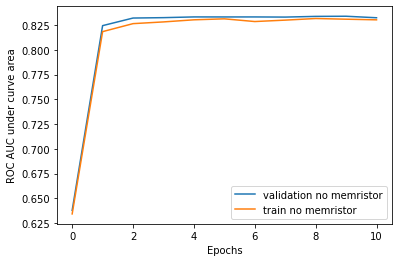

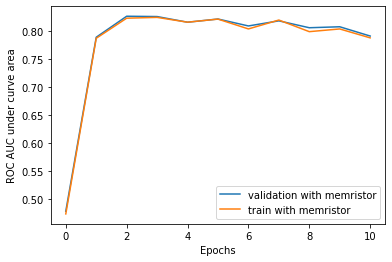

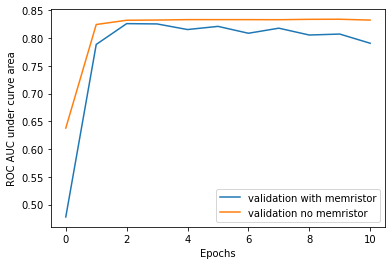

In [19]:
# Results plotting

plt.plot(S_validation_no, label = 'validation no memristor')
plt.plot(S_train_no, label = 'train no memristor')
plt.xlabel("Epochs")        
plt.ylabel("ROC AUC under curve area")
plt.legend()
plt.show()

plt.plot(S_validation_yes, label = 'validation with memristor')
plt.plot(S_train_yes, label = 'train with memristor')
plt.xlabel("Epochs")        
plt.ylabel("ROC AUC under curve area")
plt.legend()
plt.show()

plt.plot(S_validation_yes, label = 'validation with memristor')
plt.plot(S_validation_no, label = 'validation no memristor')
plt.xlabel("Epochs")        
plt.ylabel("ROC AUC under curve area")
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import roc_curve

outputs = model_no(X_train.to(torch.double))
fpr, tpr, thresholds = roc_curve(y_train.cpu().detach(), outputs.cpu().detach())
gmeans = np.sqrt(tpr*(1-fpr))
ix = np.argmax(gmeans)
print(thresholds[ix])

# Find the best threshold

0.5198927962544747


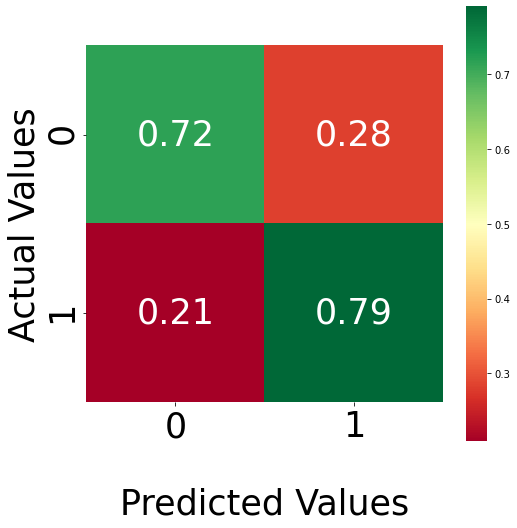

In [21]:
outputs = model_no(X_test.to(torch.double))
outputs = sklearn.preprocessing.Binarizer(threshold = 0.52).fit_transform(outputs.cpu().detach())
cf_matrix = sklearn.metrics.confusion_matrix(y_test.cpu().detach(), outputs)
cf_matrix = cf_matrix.astype(np.float)
sum_cf = np.sum(cf_matrix, axis=1)

cf_matrix[0] = cf_matrix[0]/float(sum_cf[0])
cf_matrix[1] = cf_matrix[1]/float(sum_cf[1])

fig, ax = plt.subplots(figsize=(8,8))
font_size = 35
seaborn.heatmap(cf_matrix, ax=ax, annot=True, annot_kws={"size": font_size}, cmap='RdYlGn', square = True)

ax.tick_params(labelsize=font_size)
ax.set_xlabel('\nPredicted Values', fontsize = font_size)
ax.set_ylabel('Actual Values', fontsize = font_size)

## Display the visualization of the Confusion Matrix.
plt.show()

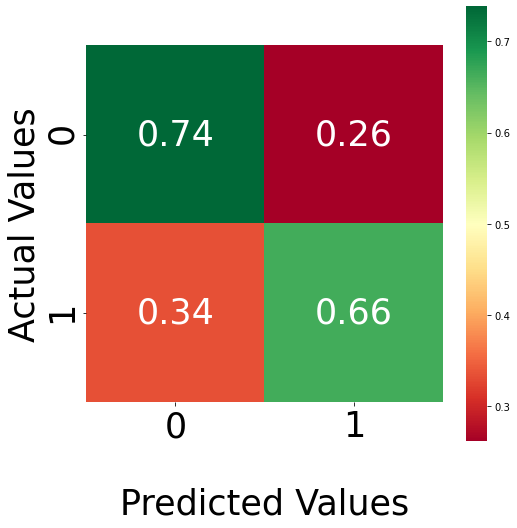

In [22]:
outputs = model_yes(X_test.to(torch.double))
outputs = sklearn.preprocessing.Binarizer(threshold = 0.52).fit_transform(outputs.cpu().detach())
cf_matrix = sklearn.metrics.confusion_matrix(y_test.cpu().detach(), outputs)
cf_matrix = cf_matrix.astype(np.float)
sum_cf = np.sum(cf_matrix, axis=1)

cf_matrix[0] = cf_matrix[0]/float(sum_cf[0])
cf_matrix[1] = cf_matrix[1]/float(sum_cf[1])

fig, ax = plt.subplots(figsize=(8,8))
font_size = 35
seaborn.heatmap(cf_matrix, ax=ax, annot=True, annot_kws={"size": font_size}, cmap='RdYlGn', square = True)

ax.tick_params(labelsize=font_size)
ax.set_xlabel('\nPredicted Values', fontsize = font_size)
ax.set_ylabel('Actual Values', fontsize = font_size)

## Display the visualization of the Confusion Matrix.
plt.show()